## Final Project :: Felipe Betancur 
How to Win a Data Science Competition: Learn from Top Kagglers :: Week 5 :: Final project

In [1]:
# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
from itertools import product
from tqdm import tqdm, tqdm_notebook

# Plot packages
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots

# TIME SERIES packages
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

#modeling packages
import sklearn
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# settings packages
import warnings
warnings.filterwarnings("ignore")
import gc

In [2]:
def downcast_dtypes(df):    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [3]:
# Data
sales=pd.read_csv("sales_train.csv.gz")
item_cat=pd.read_csv("item_categories.csv")
item=pd.read_csv("items.csv")
sub=pd.read_csv("sample_submission.csv.gz")
shops=pd.read_csv("shops.csv")
test_data=pd.read_csv("test.csv.gz")

# 01 : EDA

In [4]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
#sales date format adjustment
sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))

# check
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


In [6]:
# Aggregate to monthly level the required metrics
monthly_sales=sales.groupby(["date_block_num","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})


#Lets break down the line of code here:
#aggregate by date-block(month),shop_id and item_id
#select the columns date,item_price and item_cnt(sales)
#Provide a dictionary which says what aggregation to perform on which column
#min and max on the date
#average of the item_price
#sum of the sales

   item_category_id  item_cnt_day
0                83       12032.0
1                82       10437.0
2                81         965.0
3                80        6136.0
4                79       15830.0
5                78        2551.0
6                77        3900.0
7                76        5647.0
8                75       48224.0
9                74          59.0


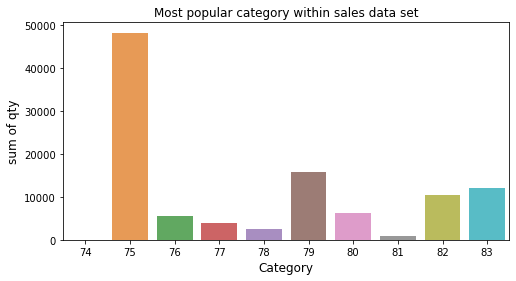

In [7]:
# Most popular category within sales data set
x= sales.merge(item,how='left',on='item_id')
x=x.groupby(['item_category_id']).agg({"item_cnt_day":"sum"})
x=x.sort_values(by='item_category_id',ascending=False)
x=x.iloc[0:10].reset_index()
print(x)

#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.item_category_id, x.item_cnt_day, alpha=0.8)
plt.title("Most popular category within sales data set")
plt.ylabel('sum of qty', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()


         item_cnt_day
shop_id              
31           310777.0
25           241920.0
54           185790.0
28           184557.0
42           144934.0
57           141107.0
27           136657.0
6            100489.0
58            81734.0
46            78990.0
56            78079.0
50            76238.0
12            73478.0
19            73455.0
15            71201.0
35            69016.0
21            68560.0
26            67890.0
47            67637.0
7             67058.0


Text(0.5, 1.0, 'Popular shops')

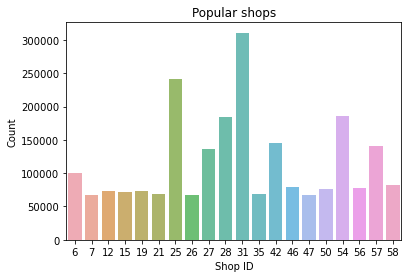

In [8]:
# most popular store whitin dataset 
popular_shops = sales.groupby(['shop_id']).agg({"item_cnt_day":"sum"})
popular_shops = popular_shops.sort_values(by='item_cnt_day',ascending=False)[:20]
print(popular_shops)

sns.barplot(popular_shops.index, popular_shops.item_cnt_day, alpha=0.8)
plt.xlabel("Shop ID")
plt.ylabel("Count")
plt.title("Popular shops")

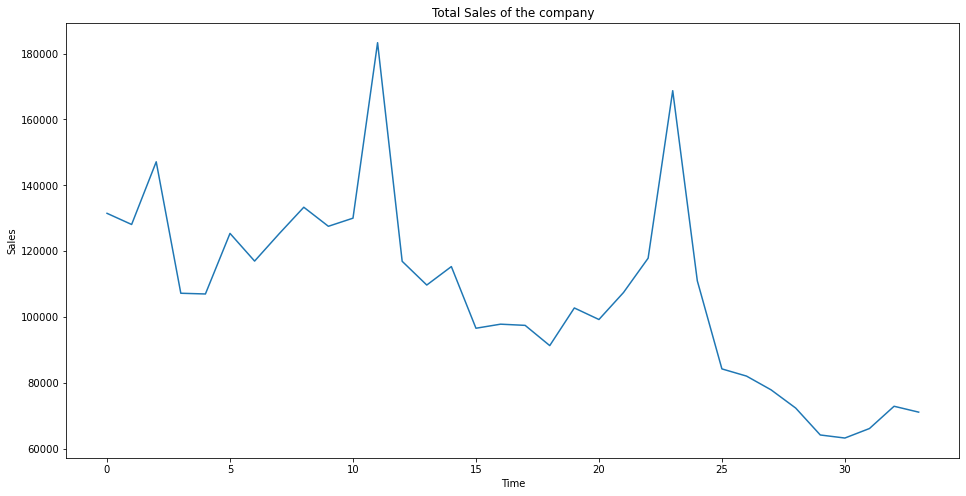

In [9]:
# compute the total sales per month and plot that data.
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

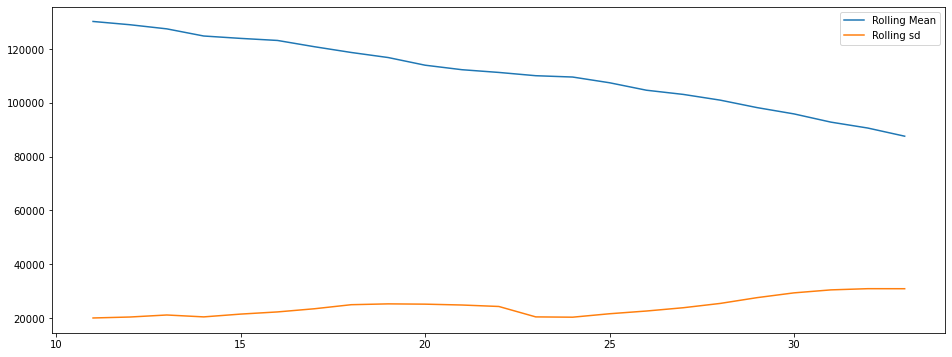

In [10]:
#global trend sum of qty time series
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

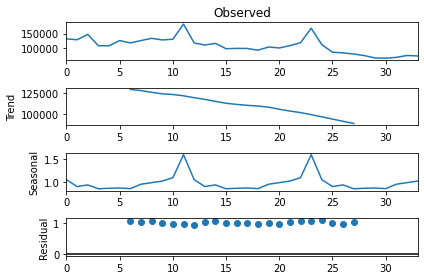

In [11]:
#Quick observations: There is an obvious "seasonality" (Eg: peak sales around a time of year) and a decreasing "Trend".
#Let's check that with a quick decomposition into Trend, seasonality and residuals.

import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()


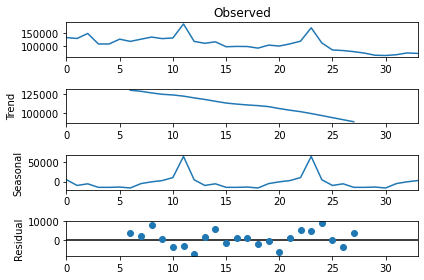

In [12]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

In [13]:
# Stationarity tests
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


In [14]:
# to remove trend
from pandas import Series as Series

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

[]

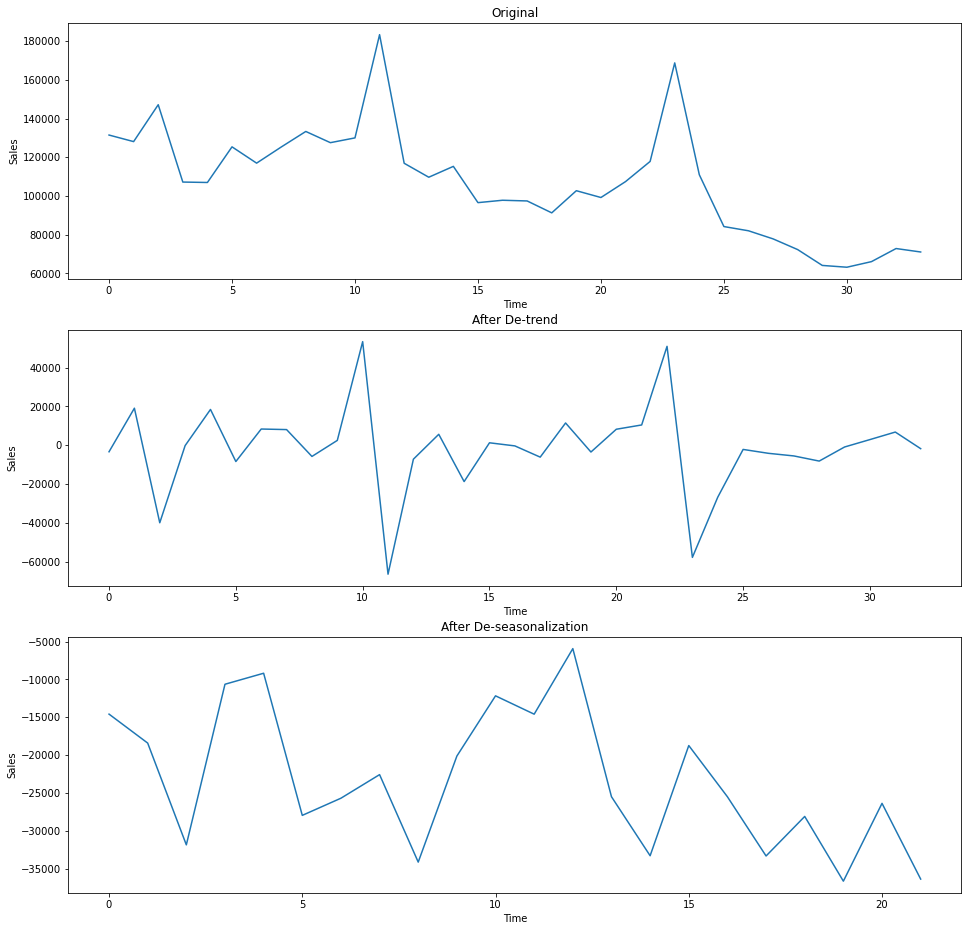

In [15]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts,12)       # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()

In [16]:
# now testing the stationarity again after de-seasonality
test_stationarity(new_ts)

Results of Dickey-Fuller Test:
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


In [17]:
#Now after the transformations, our p-value for the DF test is well within 5 %. 
#Hence we can assume Stationarity of the sum of qty series

Text(0.5, 1.0, 'Total price of items sold in each month')

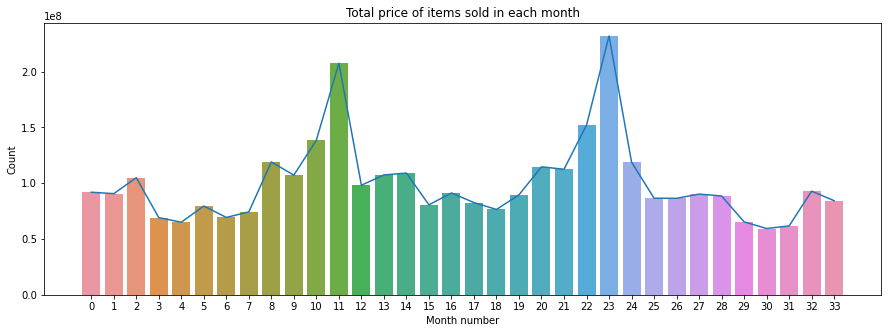

In [18]:
#qty*price time series
price_cnt_month = sales.groupby(["date_block_num","item_price"]).agg({"item_price":"max","item_cnt_day":"sum"})

price_cnt_month["to"] = price_cnt_month.item_price*price_cnt_month.item_cnt_day
price_cnt_month = price_cnt_month.groupby(["date_block_num"])["to"].sum()
#price_cnt_month = pd.DataFrame(data=price_cnt_month["to"])

plt.figure(figsize=(15,5))
sns.barplot(price_cnt_month.index, price_cnt_month.values)
plt.plot(price_cnt_month.index, price_cnt_month.values)
plt.xlabel("Month number")
plt.ylabel("Count")
plt.title("Total price of items sold in each month")

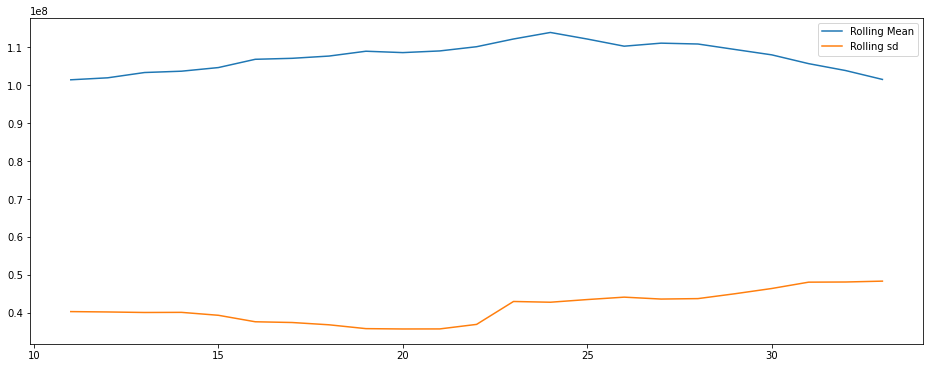

In [19]:
#global trend sum for qty*price time series
plt.figure(figsize=(16,6))
plt.plot(price_cnt_month.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(price_cnt_month.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

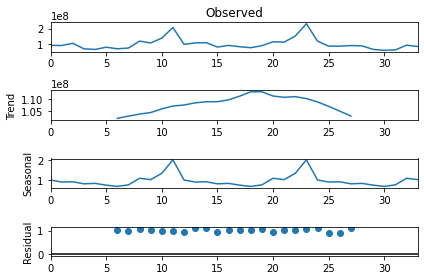

In [20]:
# quick decomposition into Trend, seasonality and residuals for qty*price time series.

import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(price_cnt_month.values,freq=12,model="multiplicative")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

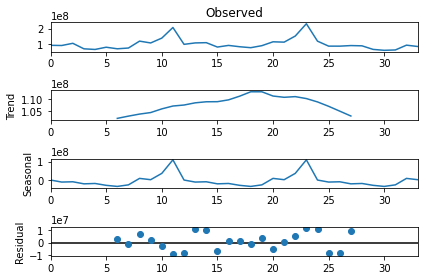

In [21]:
# Additive model for qty*price time series.
res = sm.tsa.seasonal_decompose(price_cnt_month.values,freq=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

In [22]:
# Stationarity tests
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(price_cnt_month)

Results of Dickey-Fuller Test:
Test Statistic                 -3.516314
p-value                         0.007578
#Lags Used                      9.000000
Number of Observations Used    24.000000
Critical Value (1%)            -3.737709
Critical Value (5%)            -2.992216
Critical Value (10%)           -2.635747
dtype: float64


[]

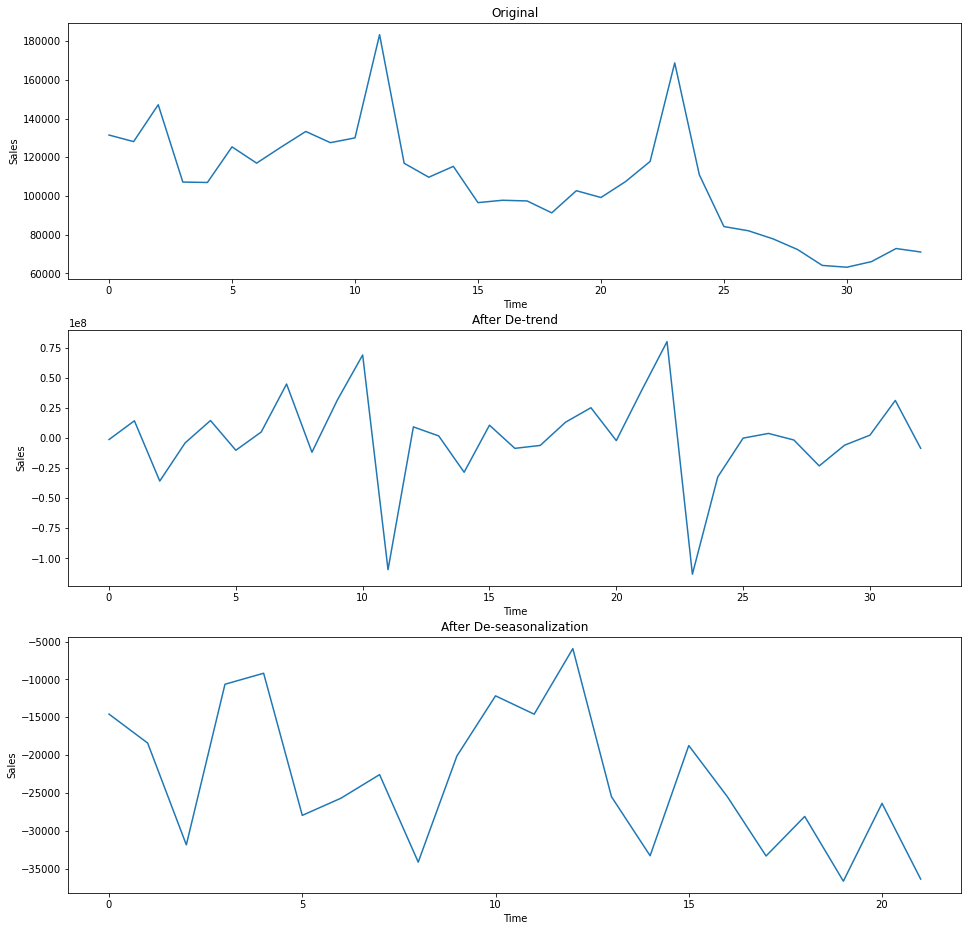

In [23]:
#original
#ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
price_cnt_month.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)

#after de-trend
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(price_cnt_month)
plt.plot(new_ts)
plt.plot()

#After De-seasonalization
plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts,12)       # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()

In [24]:
# now testing the stationarity again after de-seasonality
test_stationarity(new_ts)

Results of Dickey-Fuller Test:
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


In [25]:
#Now after the transformations, our p-value for the DF test is well within 5 %. 
#Hence we can assume Stationarity of the series¶


In [26]:
#Correlation between "sum of qty" and "qty * price" in each mont
np.corrcoef(ts.values, price_cnt_month.values)

array([[1.        , 0.71673985],
       [0.71673985, 1.        ]])

In [27]:
#both quantities and turnover are related

### Tryhing fb Prophet:

Open-sourced package by Facebook research.at its core, the Prophet procedure is an additive regression model with four main components:

-A piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting changepoints from the data.

-A yearly seasonal component modeled using Fourier series.

-A weekly seasonal component using dummy variables.

-A user-provided list of important holidays.


In [28]:
# take into account that max month in sales dataset is 2015-10-01
# therefore, we have to forecast 2015-11-01
# adding the dates to the Time-series as index
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.index=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
ts=ts.reset_index()
ts.head()


,index,item_cnt_day
0,2013-01-01,131479.0
1,2013-02-01,128090.0
2,2013-03-01,147142.0
3,2013-04-01,107190.0
4,2013-05-01,106970.0


In [29]:
#top down forecast item qty forecast

from fbprophet import Prophet
#prophet reqiures a pandas df at the below config 
# (date column named as DS and the value column as Y)
ts.columns=['ds','y']
model_td = Prophet( yearly_seasonality=True) #instantiate Prophet with only yearly seasonality as our data is monthly 
model_td.fit(ts) #fit the model with your dataframe

Importing plotly failed. Interactive plots will not work.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [30]:
# predict for five months in the furure and MS - month start is the frequency
future_td = model_td.make_future_dataframe(periods = 5, freq = 'MS')  
# now lets make the forecasts
forecast_td = model_td.predict(future_td)
forecast_td[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
34,2015-11-01,83193.957175,80086.386474,86471.200629
35,2015-12-01,125513.062865,122624.637449,128696.560912
36,2016-01-01,75625.688457,72764.404790,78787.468374
37,2016-02-01,40109.144355,36890.248942,43240.306195
38,2016-03-01,76664.084568,73594.557311,80015.100327


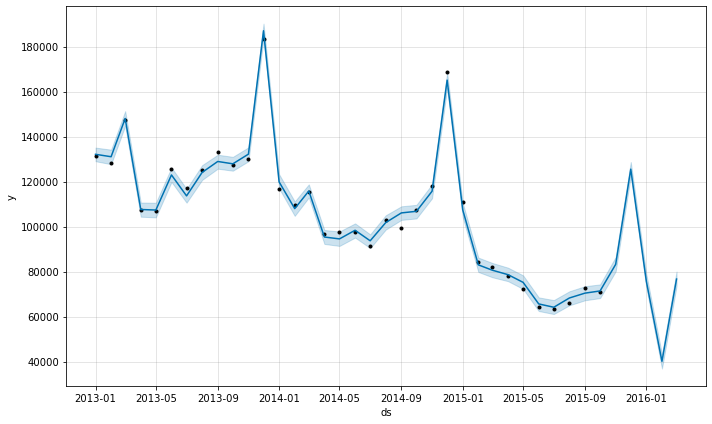

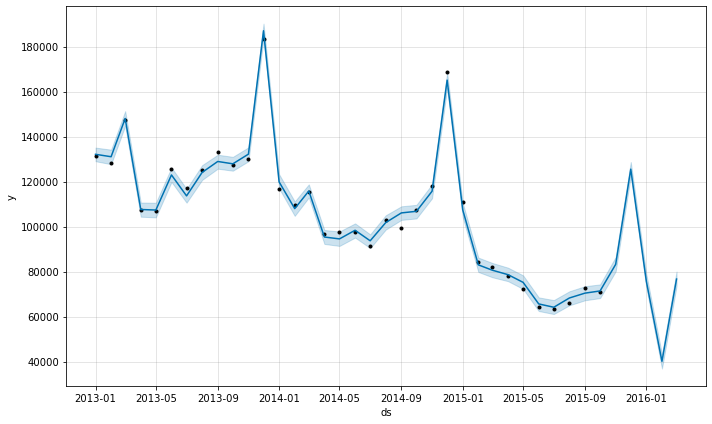

In [31]:
model_td.plot(forecast_td)

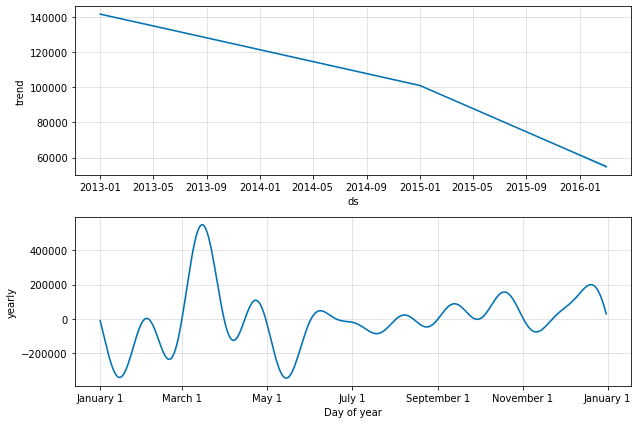

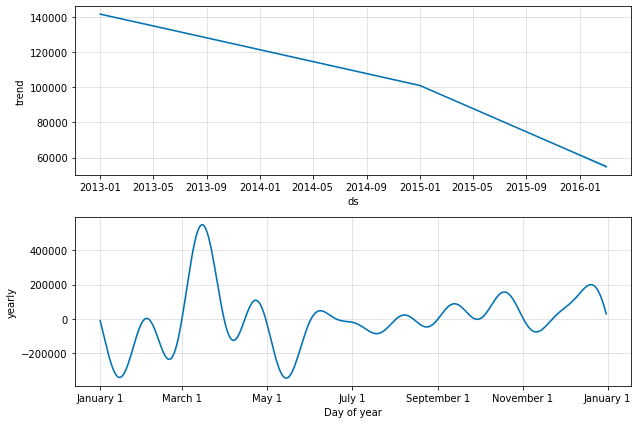

In [32]:
model_td.plot_components(forecast_td)

In [33]:
TD=forecast_td.yhat[34]
TD
#estimated total value for future period

83193.95717478567

In [34]:
#cross validation
#for measuring forecast error by comparing the predicted values with the actual valies
#initial = the size of the inicial trainig period
#period = the space between cut-off dates
#horizon = the forecast horizon
#by default, the initial training period is set to three times the horizon,a dn curoffs are made every half a horizon
from fbprophet.diagnostics import cross_validation
ts.shape

(34, 2)

In [35]:
cv = cross_validation(model_td, initial = '34 days' , period='1 days', horizon='5 days')

INFO:fbprophet:Making 32 forecasts with cutoffs between 2013-02-24 00:00:00 and 2015-09-26 00:00:00


INFO:fbprophet:n_changepoints greater than number of observations. Using 0.
INFO:fbprophet:n_changepoints greater than number of observations. Using 1.
INFO:fbprophet:n_changepoints greater than number of observations. Using 2.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.
INFO:fbprophet:n_changepoints greater than number of observations. Using 4.
INFO:fbprophet:n_changepoints greater than number of observations. Using 5.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 8.
INFO:fbprophet:n_changepoints greater than number of observations. Using 9.
INFO:fbprophet:n_changepoints greater than number of observations. Using 10.
INFO:fbprop

In [36]:

from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(cv)
df_p.head()


,horizon,mse,rmse,mae,mape,mdape,coverage
0,5 days,1.451258e+12,1.204682e+06,576212.967215,4.516454,0.430279,0.0625


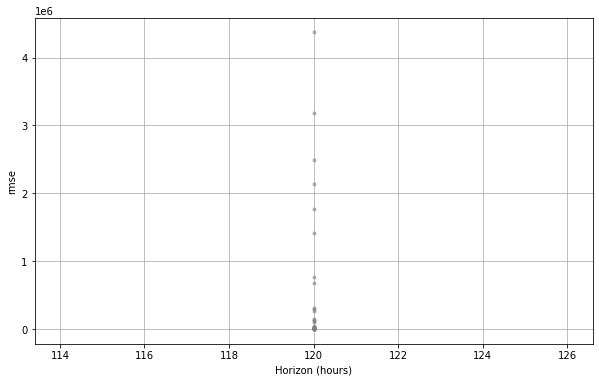

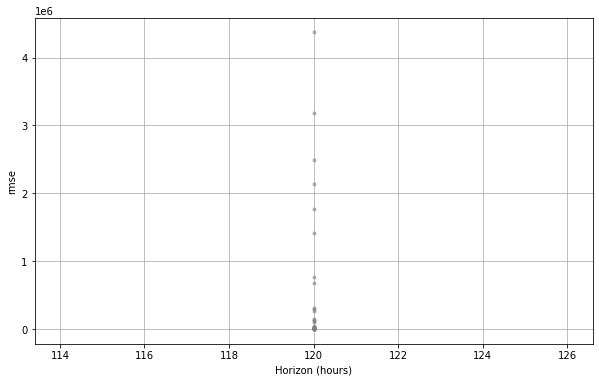

In [37]:
from fbprophet.plot import plot_cross_validation_metric
plot_cross_validation_metric(cv,metric="rmse")

In [38]:
# an aproxte 

# 02 : Preprocessing

In [39]:
#Test data - Add date_block_num=34
test_block = sales['date_block_num'].max() + 1
test_data['date_block_num'] = test_block
test_data = test_data.drop(columns=['ID'])
test_data.head()

,shop_id,item_id,date_block_num
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


In [40]:
#Create grid from all shops/items combinations from that month
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = []
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype=np.int32)
grid = pd.concat([grid, test_data])
grid.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


In [41]:
grid.describe

<bound method NDFrame.describe of         shop_id  item_id  date_block_num
0            59    22154               0
1            59     2552               0
2            59     2554               0
3            59     2555               0
4            59     2564               0
...         ...      ...             ...
214195       45    18454              34
214196       45    16188              34
214197       45    15757              34
214198       45    19648              34
214199       45      969              34

[11128050 rows x 3 columns]>

# 03 Feature Engineering

In [42]:
#Create features by grouping shops, items and mont
# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols, as_index=False)['item_cnt_day'].sum()
gb = gb.rename(columns={'item_cnt_day': 'target'})
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'], as_index=False)['item_cnt_day'].sum()
gb = gb.rename(columns={'item_cnt_day': 'target_shop'})
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'], as_index=False)['item_cnt_day'].sum()
gb = gb.rename(columns={'item_cnt_day': 'target_item'})
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

In [43]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item
0,59,22154,0,1.0,2017.0,18.0
1,59,2552,0,0.0,2017.0,0.0
2,59,2554,0,0.0,2017.0,1.0
3,59,2555,0,0.0,2017.0,2.0
4,59,2564,0,0.0,2017.0,5.0


In [44]:
all_data.describe

<bound method NDFrame.describe of           shop_id  item_id  date_block_num  target  target_shop  target_item
0              59    22154               0     1.0       2017.0         18.0
1              59     2552               0     0.0       2017.0          0.0
2              59     2554               0     0.0       2017.0          1.0
3              59     2555               0     0.0       2017.0          2.0
4              59     2564               0     0.0       2017.0          5.0
...           ...      ...             ...     ...          ...          ...
11128045       45    18454              34     0.0          0.0          0.0
11128046       45    16188              34     0.0          0.0          0.0
11128047       45    15757              34     0.0          0.0          0.0
11128048       45    19648              34     0.0          0.0          0.0
11128049       45      969              34     0.0          0.0          0.0

[11128050 rows x 6 columns]>

In [45]:
#Create features using previous months data - Different lags
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols))
shift_range = [1, 2, 3, 4, 5, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift

    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)
    
del train_shift

In [46]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,...,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12
0,59,22154,0,1.0,2017.0,18.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,59,2552,0,0.0,2017.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,59,2554,0,0.0,2017.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,59,2555,0,0.0,2017.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,59,2564,0,0.0,2017.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
all_data.describe

<bound method NDFrame.describe of           shop_id  item_id  date_block_num  target  target_shop  target_item  \
0              59    22154               0     1.0       2017.0         18.0   
1              59     2552               0     0.0       2017.0          0.0   
2              59     2554               0     0.0       2017.0          1.0   
3              59     2555               0     0.0       2017.0          2.0   
4              59     2564               0     0.0       2017.0          5.0   
...           ...      ...             ...     ...          ...          ...   
11128045       45    18454              34     0.0          0.0          0.0   
11128046       45    16188              34     0.0          0.0          0.0   
11128047       45    15757              34     0.0          0.0          0.0   
11128048       45    19648              34     0.0          0.0          0.0   
11128049       45      969              34     0.0          0.0          0.0   

     

In [48]:
#Add "item category id" as a feature
# Don't use old data from year 2012
all_data = all_data[all_data['date_block_num'] >= 12]

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]]

# We will drop these at fitting stage
to_drop_cols = ['target_item', 'target_shop', 'target', 'date_block_num']
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num']

# Category for each item
item_category_mapping = item[['item_id', 'item_category_id']].drop_duplicates()
all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)

gc.collect()

0

In [49]:
to_drop_cols

['target', 'target_shop', 'target_item', 'date_block_num']

In [50]:
#Final data - Will be used for training and validation

all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,...,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
0,54,10297,12,4.0,8198.0,23.0,3.0,42.0,10055.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,54,10296,12,3.0,8198.0,17.0,0.0,24.0,10055.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38
2,54,10298,12,14.0,8198.0,182.0,21.0,369.0,10055.0,119.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
3,54,10300,12,3.0,8198.0,26.0,1.0,54.0,10055.0,31.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
4,54,10284,12,1.0,8198.0,3.0,0.0,4.0,10055.0,0.0,...,0.0,3.0,7827.0,0.0,10.0,7792.0,0.0,0.0,0.0,57


In [51]:
all_data.describe

<bound method NDFrame.describe of          shop_id  item_id  date_block_num  target  target_shop  target_item  \
0             54    10297              12     4.0       8198.0         23.0   
1             54    10296              12     3.0       8198.0         17.0   
2             54    10298              12    14.0       8198.0        182.0   
3             54    10300              12     3.0       8198.0         26.0   
4             54    10284              12     1.0       8198.0          3.0   
...          ...      ...             ...     ...          ...          ...   
6639289       45    18454              34     0.0          0.0          0.0   
6639290       45    16188              34     0.0          0.0          0.0   
6639291       45    15757              34     0.0          0.0          0.0   
6639292       45    19648              34     0.0          0.0          0.0   
6639293       45      969              34     0.0          0.0          0.0   

         target_l

## 04 DATA SPLITTING (TRAIN & TEST)

In [52]:
dates = all_data['date_block_num']

dates_train  = dates[dates <  test_block]
dates_test  = dates[dates == test_block]

X_train = all_data.loc[dates <  test_block].drop(to_drop_cols, axis=1)
X_test =  all_data.loc[dates == test_block].drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  test_block, 'target'].values
y_test =  all_data.loc[dates == test_block, 'target'].values

In [53]:
X_train.head()

,shop_id,item_id,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,...,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
0,54,10297,3.0,42.0,10055.0,0.0,2.0,7978.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,54,10296,0.0,24.0,10055.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38
2,54,10298,21.0,369.0,10055.0,119.0,1309.0,7978.0,7.0,144.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
3,54,10300,1.0,54.0,10055.0,31.0,361.0,7978.0,0.0,53.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
4,54,10284,0.0,4.0,10055.0,0.0,3.0,7978.0,0.0,5.0,...,0.0,3.0,7827.0,0.0,10.0,7792.0,0.0,0.0,0.0,57


In [54]:
y_train

array([ 4.,  3., 14., ...,  0.,  0.,  0.], dtype=float32)

In [55]:
#Target range - Clip it to [0, 20]

target_range = [0, 20]
target_range

[0, 20]

## 05 Modeling

In [56]:
#Linear Regression
#given the type of ML problem (forecast prediction) and the Stationarity of the series, Linear Regression
# seems a basic aproach to endure this challenge

lr = LinearRegression()
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_test.values).clip(*target_range)

In [57]:
submission_lr = pd.DataFrame({'ID': sub.ID, 'item_cnt_month': pred_lr})
submission_lr.to_csv('submission_linear_regression.csv', index=False)

In [58]:
submission_lr.item_cnt_month.sum()

65254.27224225065

In [59]:
#LightGBM
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7,
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_lgb = model.predict(X_test).clip(*target_range)

In [60]:
submission_lgb = pd.DataFrame({'ID': sub.ID, 'item_cnt_month': pred_lgb})
submission_lgb.to_csv('submission_lgb.csv', index=False)

In [61]:
submission_lgb.item_cnt_month.sum()

63731.98044030043

In [62]:
#Concatenate test predictions to get test meta -features
X_test_level2 = np.c_[pred_lr, pred_lgb]
X_test_level2

array([[0.59513646, 0.45047173],
       [0.10165797, 0.15679661],
       [0.95515631, 0.84702682],
       ...,
       [0.08131603, 0.04771994],
       [0.1054668 , 0.04511831],
       [0.09177211, 0.04511831]])

## 06 Validation - Second level

In [63]:
#Train meta-features
dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32, 33])]


# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin(dates_train_level2)]

### Time series data - Use 2nd level validation scheme accordingly

**KFold scheme in time series**

In time-series tasks we usually have a fixed period of time we are asked to predict. Like day, week, month or arbitrary period with duration of T.
- Split the train data into chunks of duration T. Select first M chunks.
- Fit N diverse models on those M chunks and predict for the chunk M+1. Then fit those models on first M+1 chunks and predict for chunk M+2 and so on, until you hit the end. After that use all train data to fit models and get predictions for test. Now we will have meta-features for the chunks starting from number M+1 as well as meta-features for the test.
- Now we can use meta-features from first K chunks [M+1,M+2,..,M+K] to fit level 2 models and validate them on chunk M+K+1. Essentially we are back to step 1. with the lesser amount of chunks and meta-features instead of features.

In [64]:
# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

# Now fill `X_train_level2` with metafeatures
for cur_block_num in [27, 28, 29, 30, 31, 32, 33]:
    print(cur_block_num)
    '''
        1. Spliting `X_train` into parts
           Corresponding dates are stored in `dates_train` 
        2. Fitting linear regression 
        3. Fitting LightGBM and put predictions          
        4. Storing predictions from 2. and 3. in the right place of `X_train_level2`. 
           Using `dates_train_level2` for storing predictions from 2. and 3.
           Making sure the order of the meta-features is the same as in `X_test_level2`
    '''      
    X_train_cur = all_data.loc[dates <  cur_block_num].drop(to_drop_cols, axis=1)
    X_test_cur =  all_data.loc[dates == cur_block_num].drop(to_drop_cols, axis=1)

    y_train_cur = all_data.loc[dates <  cur_block_num, 'target'].values
    y_test_cur =  all_data.loc[dates == cur_block_num, 'target'].values
    
    lr.fit(X_train_cur.values, y_train_cur)
    pred_lr = lr.predict(X_test_cur.values)
    X_train_level2[dates_train_level2 == cur_block_num, 0] = pred_lr.clip(*target_range)
    
    model = lgb.train(lgb_params, lgb.Dataset(X_train_cur, label=y_train_cur), 100)
    pred_lgb = model.predict(X_test_cur)
    X_train_level2[dates_train_level2 == cur_block_num, 1] = pred_lgb.clip(*target_range)

27
28
29
30
31
32
33


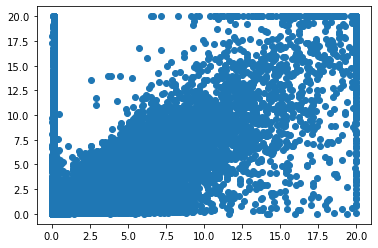

In [65]:
#Correlation between predictions of different methods

plt.scatter(X_train_level2[:, 0], X_train_level2[:, 1])

## 07 ENSEMBLING

In [66]:
#Ensembling - Simple averaging
#(alpha) * linear_regression + (1-alpha) * lightgbm

alphas_to_try = np.linspace(0, 1, 1001)

r2_scores = []
for alpha in alphas_to_try:
    mix = alpha*X_train_level2[:,0] + (1-alpha)*X_train_level2[:,1]
    r2_scores.append(r2_score(y_train_level2, mix))

r2_scores = np.array(r2_scores)


best_alpha = alphas_to_try[r2_scores.argmax()]
r2_train_simple_mix = r2_scores.max()

print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))

Best alpha: 0.044000; Corresponding r2 score on train: 0.083836


In [67]:
pred_simple_averaging = best_alpha*X_test_level2[:,0] + (1-best_alpha)*X_test_level2[:,1]
submission_avg = pd.DataFrame({'ID': sub.ID, 'item_cnt_month': pred_simple_averaging})
submission_avg.to_csv('submission_simple_averaging.csv', index=False)

In [68]:
submission_avg.item_cnt_month.sum()

63798.96127958625

In [69]:
#Ensembling - Stacking
#Train second level data

lr.fit(X_train_level2, y_train_level2)

LinearRegression()

In [71]:
pred_stacking = lr.predict(X_test_level2).clip(*target_range)

In [72]:
submission_stk = pd.DataFrame({'ID': sub.ID, 'item_cnt_month': pred_stacking})
submission_stk.to_csv('submission_stacking.csv', index=False)

In [73]:
pred_stacking

array([0.64046058, 0.0753553 , 1.28452979, ..., 0.        , 0.        ,
       0.        ])

In [75]:
submission_stk.item_cnt_month.sum()

75326.14912099688

### Conclusion
- All models generated similiar  total 'item_cnt_month' sum quantities, compared to the initial Prophet forecast (additive regression model = 83193.95717478567) 
- Tranforming the initial dataset (preprocessing) and Adding features, increased the public leaderboard score substantially.
- Simple averaging worked better than Stacking.